# MobileNet

## Install Libraries

In [1]:
%pip install tensorflow matplotlib numpy tensorflow-datasets


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load Libraries

In [2]:
import os
import random
import itertools
import shutil
import tarfile
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, ReLU, Input, Conv2D, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

2024-07-20 15:41:59.274362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 15:41:59.278169: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 15:41:59.289860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 15:41:59.308036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 15:41:59.313061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 15:41:59.326050: I tensorflow/core/platform/cpu_feature_gu

## Load Data

In [3]:
(train_data, test_data), info = tfds.load('cifar10',
                                          split=('train[:80%]', 'train[80%:]'),
                                          with_info=True,
                                          as_supervised=True)

## Data Exploration

In [4]:
len(train_data), len(test_data)

(40000, 10000)

In [5]:
for X, y in train_data:
    print(X.shape, y.numpy())
    image_1 = X.numpy()
    break

(32, 32, 3) 7


2024-07-20 15:42:02.330187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


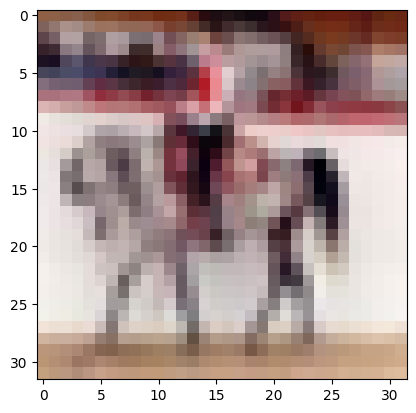

In [6]:
plt.imshow(image_1)

## Preprocess Data

In [7]:
def normalize_img(image, label):
    return ((tf.cast(image, tf.float32)) / 255.0, label)

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

def augment(image, label):
    return data_augmentation(image), label

In [8]:
train_data = train_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
SHUFFLE_VAL = len(train_data) // 1000
BATCH_SIZE = 64

train_data = train_data.shuffle(SHUFFLE_VAL)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [10]:
test_data = test_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

## Building the Model

In [11]:
def mobilenet_block(x, filters, strides):   
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', depthwise_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    x = ReLU()(x)
    return x

In [12]:
input = Input(shape=(32, 32, 3))

x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(0.001))(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)
x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)
x = Dropout(0.3)(x)
x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)
x = Dropout(0.3)(x)
x = mobilenet_block(x, filters=512, strides=2)
x = mobilenet_block(x, filters=512, strides=1)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(units=10, activation='softmax')(x)

model = Model(inputs=input, outputs=output)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 32, 32, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 16, 16, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,842 (2.11 MB)

 Trainable params: 546,314 (2.08 MB)

 Non-trainable params: 6,528 (25.50 KB)

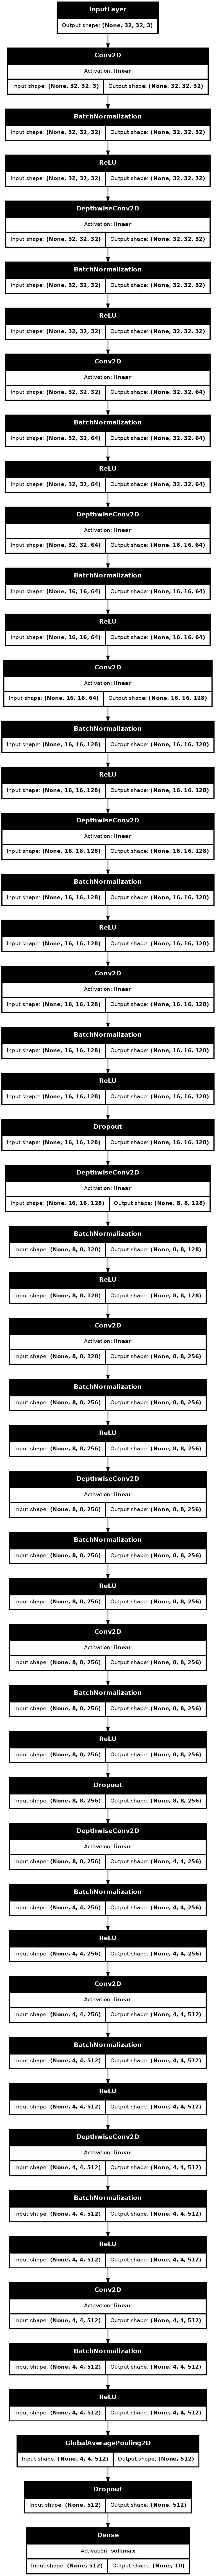

In [13]:
model.summary()

plot_model(model,
           to_file='./images/mobilenet_architecture.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=False,
           show_layer_activations=True,
           dpi=100)

In [14]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [16]:
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)


In [17]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 324ms/step - accuracy: 0.1472 - loss: 3.8970 - val_accuracy: 0.1052 - val_loss: 4.2987
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 297ms/step - accuracy: 0.2687 - loss: 3.4052 - val_accuracy: 0.3829 - val_loss: 3.0121
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 310ms/step - accuracy: 0.3155 - loss: 3.1811 - val_accuracy: 0.4070 - val_loss: 2.8646
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 306ms/step - accuracy: 0.3457 - loss: 3.0068 - val_accuracy: 0.4255 - val_loss: 2.7166
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 299ms/step - accuracy: 0.3740 - loss: 2.8524 - val_accuracy: 0.4361 - val_loss: 2.6013
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 298ms/step - accuracy: 0.3908 - loss: 2.7283 - val_accuracy: 0.4567 - val_loss: 2.4927
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 298ms/step - accuracy: 0.4068 - loss: 2.6065 - val_accuracy: 0.4641 - val_loss: 2.3785
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 

## Plot Training History

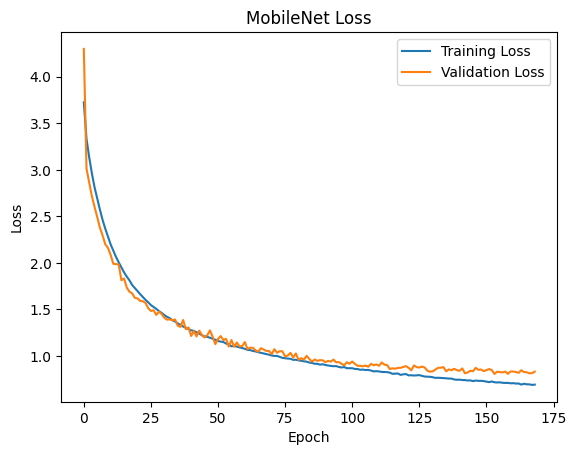

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('MobileNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

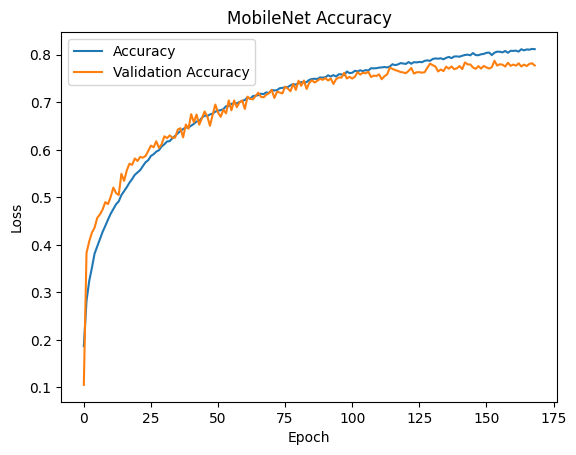

In [19]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('MobileNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()